**В домашней работе необходимо выполнить следующее задание:**

1. Используя предложенный [датасет](https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip) произведений классической музыки, обучи модель "сочинять" музыку на произведениях только одного Шопена.
2. В качестве начальной последовательности для генерации используйте произведения Моцарта.
3. Для получения трех баллов достаточно получить ноты и аудиофайл с вашим сгенерированным произведением.
4. Хотите 4 балла? Добавьте в функцию генерации параметр `temperature` - температура модели. Температура модели влияет на генерацию. Более низкие температуры соответствуют более точному предсказанию, а более высокие температуры приводят к более случайной генерации.
5. Хотите 5 баллов? Используйте для обучения модели три переменные для представления ноты: pitch, step и duration. Высота звука (pitch) - это качество восприятия звука в виде номера ноты в формате MIDI. Шаг (step) - это время, прошедшее с предыдущей ноты или начала трека. Длительность (duration) - это продолжительность воспроизведения ноты в секундах и разница между временем окончания и началом ноты.

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21
!pip install pretty_midi

In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip

In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset

In [ ]:
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense
from keras.src.utils import to_categorical
from music21 import *
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import music21
import fluidsynth
import matplotlib.pyplot as plt
import pretty_midi

import sys
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:
!dir ./dataset

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:
CLASS_LIST = ["Chopin", "Mozart"]

In [ ]:
all_midis = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath + i
            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append([midi, compositor])

In [ ]:
def getNotes(file, compositor):
    notes = []
    notes_start = []
    notes_to_parse = None
    for j, c in file:
        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)
        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch)) if c != compositor else notes_start.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    accord = ".".join(str(n) for n in element.normalOrder)
                    notes.append(accord) if c != compositor else notes_start.append(accord)

    return notes, notes_start

In [ ]:
# В getNotes подается все midi, второй аргумент - это, что будет использоваться, в качестве начальной последовательности
Corpus, Corpus_start = getNotes(all_midis, "Mozart")
print("Всего нот во всех midi-файлах всего датасета + начальный:", len(Corpus + Corpus_start))

In [ ]:
count_num = Counter(Corpus + Corpus_start)
print("Общее число уникальных нот в обоих корпусах:", len(count_num))

Общее число уникальных нот в обоих корпусах: 408


In [ ]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 278.6666666666667
Наиболее часто встречаемые ноты: 3236 раз
Наиболее редкие ноты: 1 раз


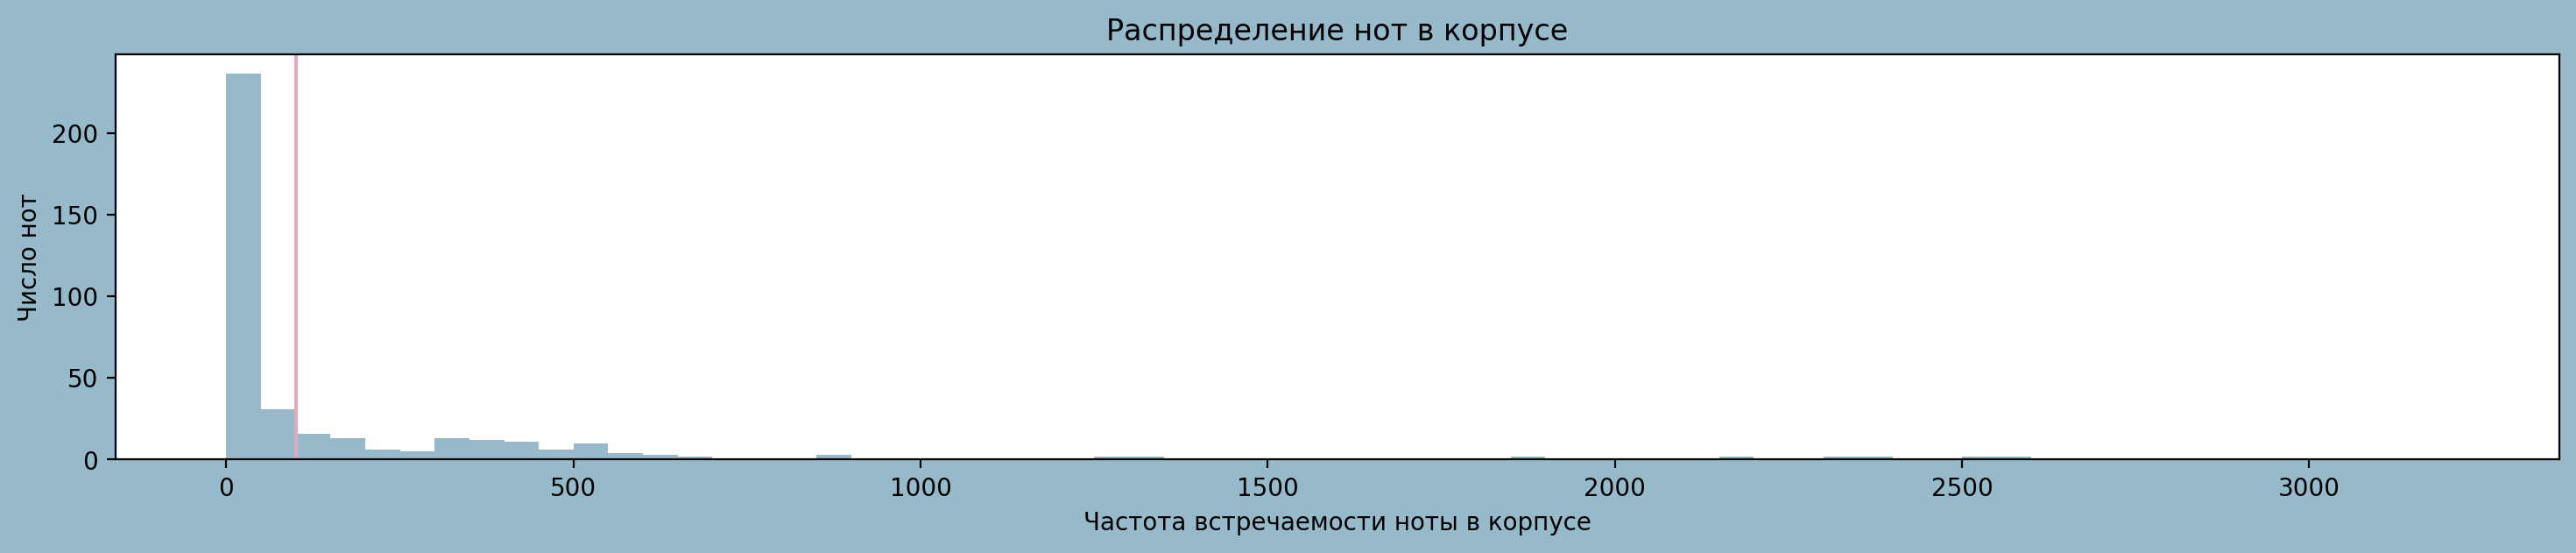

In [ ]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [ ]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m = key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 267


In [ ]:
# Удаление редких нот
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

for element in Corpus_start:
    if element in rare_note:
        Corpus_start.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus + Corpus_start))

Длина корпуса после исключения редких нот: 109512


In [ ]:
# Сохраняем все уникальные значения корпусов
symb = sorted(list(set(Corpus + Corpus_start)))

L_corpus = len(Corpus)  # длина корпуса
L_corpus_start = len(Corpus_start)  # длина начального корпуса

L_symb = len(symb)  # число уникальных элементов корпусов

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов в тренировочных данных:", L_corpus)
print("Общее число символов в начальных данных:", L_corpus_start)
print("Число уникальных символов:", L_symb)

Общее число символов в тренировочных данных: 54643
Общее число символов в начальных данных: 54869
Число уникальных символов: 263


In [ ]:
# Разбиение корпуса на равные входные строки и выходные целевые последовательности

# длинны последовательностей
length = 40
# входные последовательности
features = []
features_start = []
# целевые последовательности
targets = []
targets_start = []

# цикл разбиения тренировочного корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

# цикл разбиения начального корпуса
for i in range(0, L_corpus_start - length, 1):
    feature = Corpus_start[i:i + length]
    target = Corpus_start[i + length]
    features_start.append([mapping[j] for j in feature])
    targets_start.append(mapping[target])

L_datapoints = len(targets)
L_datapoints_start = len(targets_start)
print("Общее количество последовательностей в тренировочном корпусе:", L_datapoints)
print("Общее количество последовательностей в начальном корпусе:", L_datapoints_start)

Общее количество последовательностей в тренировочном корпусе: 54603
Общее количество последовательностей в начальном корпусе: 54829


In [ ]:
# изменение размера и нормализация входных данных
X_train = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
X_seed = (np.reshape(features_start, (L_datapoints_start, length, 1))) / float(L_symb)
# one-hot encode для целевых выходных данных
y_train = to_categorical(targets)
y_seed = to_categorical(targets_start)

print(f'Форма тренировочных входных данных: {X_train.shape}')
print(f'Форма тренировочных выходных данных: {y_train.shape}')

print(f'Форма начальных входных данных: {X_seed.shape}')
print(f'Форма начальных выходных данных: {y_seed.shape}')

Форма тренировочных входных данных: (54603, 40, 1)
Форма тренировочных выходных данных: (54603, 263)
Форма начальных входных данных: (54829, 40, 1)
Форма начальных выходных данных: (54829, 263)


In [ ]:
model = Sequential()

model.add(LSTM(256, input_shape=X_train.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=150)

Epoch 1/150
214/214 [==============================] - 10s 17ms/step - loss: 4.7872 - acc: 0.0251
Epoch 2/150
214/214 [==============================] - 3s 16ms/step - loss: 4.7204 - acc: 0.0272
Epoch 3/150
214/214 [==============================] - 3s 16ms/step - loss: 4.6314 - acc: 0.0289
Epoch 4/150
214/214 [==============================] - 4s 17ms/step - loss: 4.4994 - acc: 0.0357
Epoch 5/150
214/214 [==============================] - 3s 16ms/step - loss: 4.4891 - acc: 0.0356
Epoch 6/150
214/214 [==============================] - 3s 16ms/step - loss: 4.4732 - acc: 0.0376
Epoch 7/150
214/214 [==============================] - 3s 16ms/step - loss: 4.4708 - acc: 0.0371
Epoch 8/150
214/214 [==============================] - 4s 17ms/step - loss: 4.4580 - acc: 0.0373
Epoch 9/150
214/214 [==============================] - 3s 16ms/step - loss: 4.4481 - acc: 0.0373
Epoch 10/150
214/214 [==============================] - 3s 16ms/step - loss: 4.4416 - acc: 0.0392
Epoch 11/150
214/214 [======

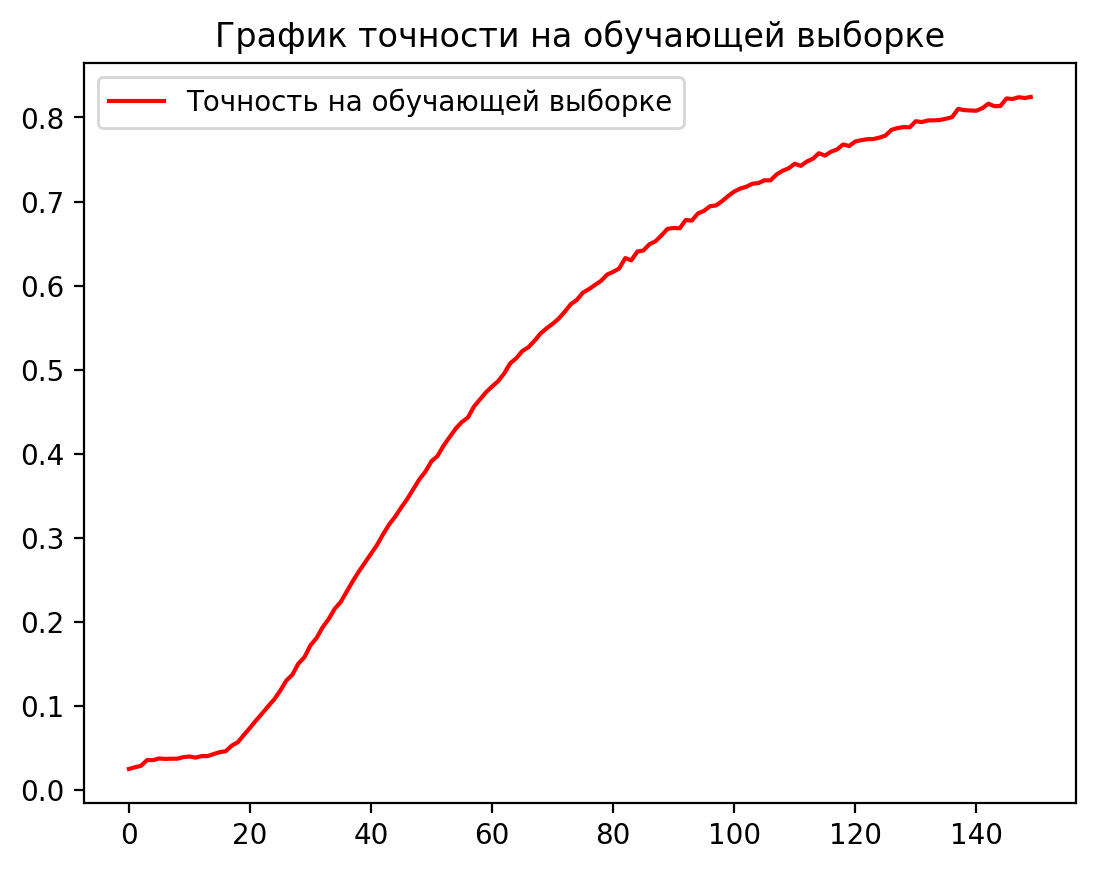

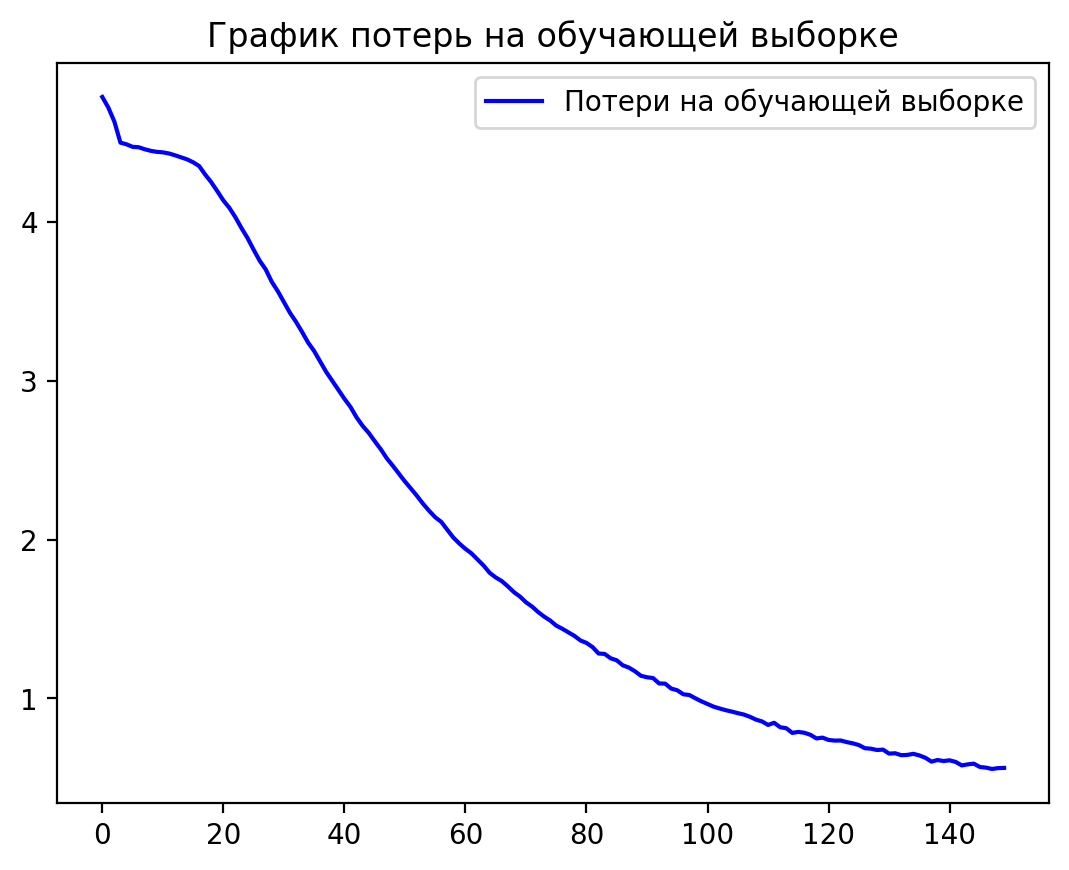

In [ ]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0  # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")  # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1

    return Melody

In [ ]:
def music_generator(seq_len, temperature=1.0):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed) - 1)]
    music = []
    notes = []
    for i in range(seq_len):

        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]
        prediction = prediction / temperature

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]
    return chords_n_notes(music)

In [ ]:
genMusic = music_generator(100, temperature=0.5)
genMidi = stream.Stream(genMusic)

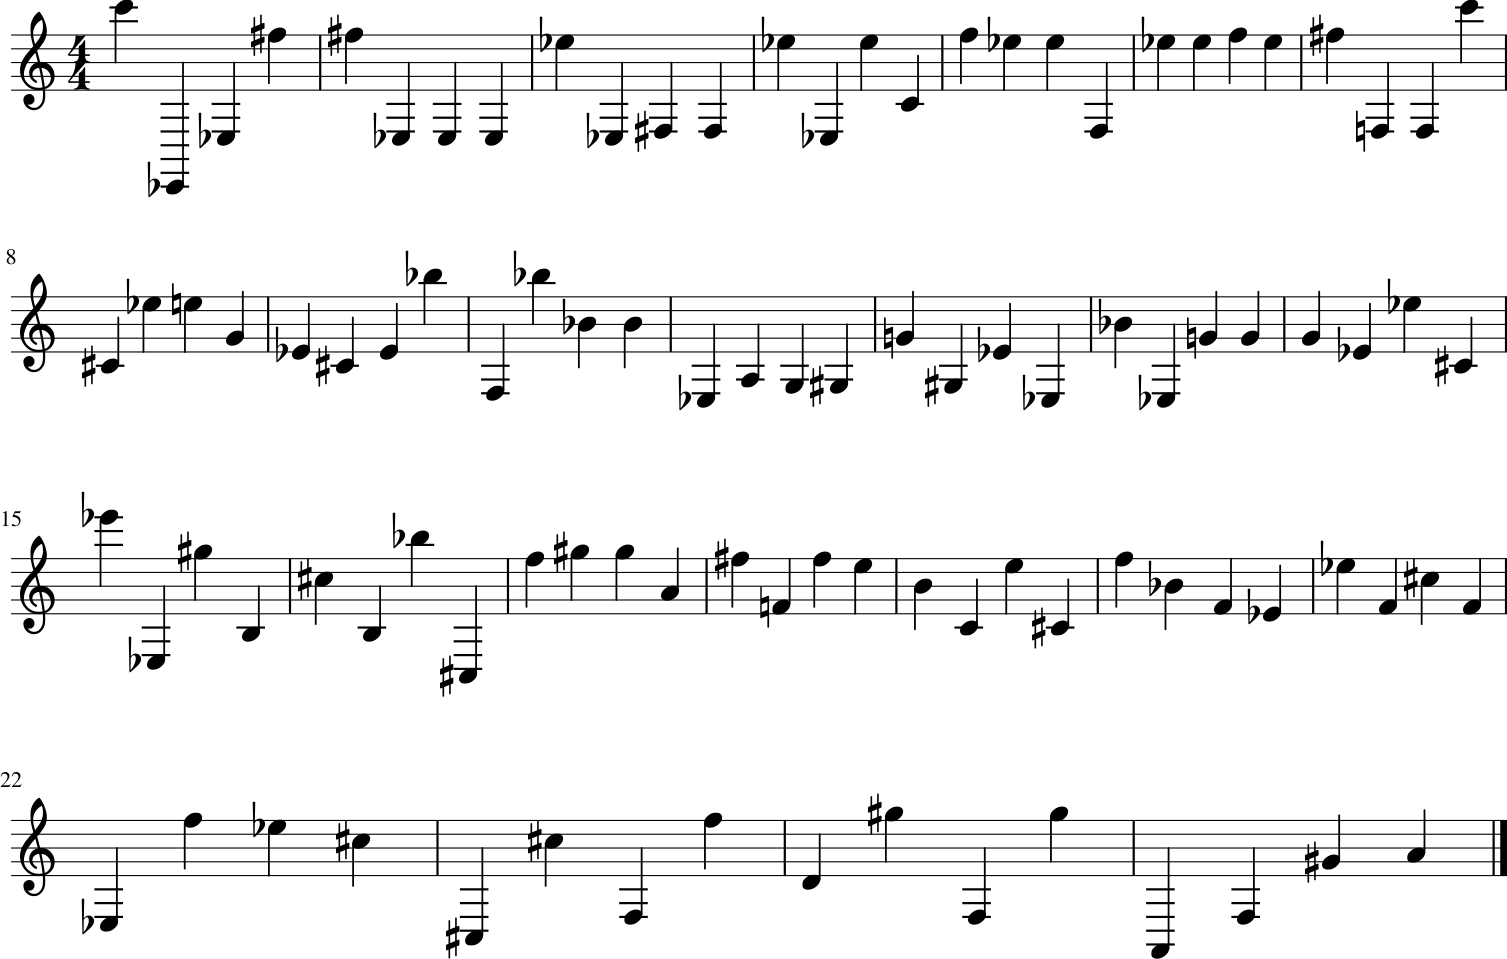

In [ ]:
# Отобразим нотный стан
genMidi.show()

In [ ]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')